# Исследование методов уменьшения переобучения нейронных сетей на примере модернизированной сети LeNet на датасете CIFAR

Дисциплина: "**Системы поддержки принятия решений**"

**Подготовил**: Лосев А. П., гр. ИСТ-131м.

**Принял**: к.т.н., доцент кафедры ИУС, Литвинов В. Л.

Импорт необходимых зависимостей и инициализация *random seed*:

In [1]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

Импорт встроенных наборов для обучения:

In [2]:
import torchvision.datasets

Загрузка датасетов CIFAR для обучения и валидации результатов:

In [3]:
CIFAR_train = torchvision.datasets.CIFAR10('./', download=True, train=True)
CIFAR_test = torchvision.datasets.CIFAR10('./', download=True, train=False)

Files already downloaded and verified
Files already downloaded and verified


Размещение загруженных датасетов в переменные:

In [4]:
X_train = torch.FloatTensor(CIFAR_train.data)
y_train = torch.LongTensor(CIFAR_train.targets)
X_test = torch.FloatTensor(CIFAR_test.data)
y_test = torch.LongTensor(CIFAR_test.targets)

Вывод информации о количестве индивидуальных единиц данных в датасетах:

In [5]:
len(y_train), len(y_test)

(50000, 10000)

Вывод информации о максимальном и минимальном значении для изображений:

In [6]:
X_train.min(), X_train.max()

(tensor(0.), tensor(255.))

Деление значений в датасете на 255 для удобства манипулирования:

In [7]:
X_train /= 255.
X_test /= 255.

Вывод информации о классах изображений, используемых в датасете CIFAR:

In [8]:
CIFAR_train.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Вывод изображений из датасета CIFAR для визуальной оценки и сопоставления с номерами тензоров:

tensor(0)    tensor(6)    tensor(6)    tensor(1)    tensor(6)    tensor(3)    tensor(1)    tensor(0)    tensor(9)    

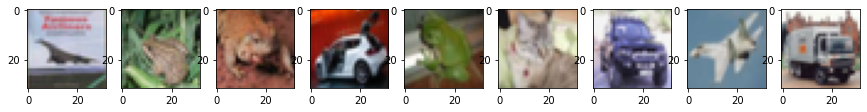

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
for i in range(3, 12):
    plt.subplot(3, 12, i+1)
    plt.imshow(X_test[i])
    print(y_test[i], end='    ')

Вывод информации о размерности набора данных для обучения, где указано количество изображений (**50000**) и размерность тензора изображения (**32x32x3**):

In [10]:
X_train.shape, y_train.shape

(torch.Size([50000, 32, 32, 3]), torch.Size([50000]))

Перестановка последовательности информации в тензоре для удобства работы (первоочерёдно — каналы цвета (**3**), после — размерность изображения(**32x32**)):

In [11]:
X_train = X_train.permute(0, 3, 1, 2)
X_test = X_test.permute(0, 3, 1, 2)

Вывод информации о размерности набора данных для обучения, где указано количество изображений (**50000**) и размерность тензора изображения (**3x32x32**):

In [12]:
X_train.shape

torch.Size([50000, 3, 32, 32])

Создание функции, осуществляющей обучение нейронной сети:

In [13]:
def train(X_train, y_train, X_test, y_test):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3, weight_decay=1e-5)
    
    batch_size = 100

    test_accuracy_history = []
    test_loss_history = []

    X_test = X_test.to(device)
    y_test = y_test.to(device)

    for epoch in range(50):
        order = np.random.permutation(len(X_train))
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            net.train()

            batch_indexes = order[start_index:start_index+batch_size]

            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)

            preds = net.forward(X_batch)

            loss_value = loss(preds, y_batch)
            loss_value.backward()

            optimizer.step()
            
        net.eval()
        with torch.no_grad(): 
             test_preds = net.forward(X_test)
            
        test_loss_history.append(loss(test_preds, y_test).data.cpu())

        accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
        test_accuracy_history.append(accuracy)
        
        print(accuracy)
    print('---------------')    
    return test_accuracy_history, test_loss_history

accuracies = {}
losses = {}

Создание модели нейронной сети с заданной архитектурой:

In [14]:
class CIFARNet(torch.nn.Module):
    def __init__(self):
        super(CIFARNet, self).__init__()
        self.batch_norm0 = torch.nn.BatchNorm2d(3)
#         self.batch_drop0 = torch.nn.Dropout2d(p=0.15, inplace=False)
#         self.batch_drop2 = torch.nn.Dropout2d(p=0.15, inplace=False)
#         self.batch_drop1 = torch.nn.Dropout(p=0.15, inplace=False)

        self.conv1 = torch.nn.Conv2d(3, 16, 3, padding=1)
        self.act1  = torch.nn.ReLU()
        self.batch_norm1 = torch.nn.BatchNorm2d(16)
        self.pool1 = torch.nn.MaxPool2d(2, 2)
        
        self.conv2 = torch.nn.Conv2d(16, 32, 3, padding=1)
        self.act2  = torch.nn.ReLU()
        self.batch_norm2 = torch.nn.BatchNorm2d(32)
        self.pool2 = torch.nn.MaxPool2d(2, 2)
        
        self.conv3 = torch.nn.Conv2d(32, 64, 3, padding=1)
        self.act3  = torch.nn.ReLU()
        self.batch_norm3 = torch.nn.BatchNorm2d(64)

        self.fc1   = torch.nn.Linear(8 * 8 * 64, 256)
        self.act4  = torch.nn.Tanh()
        self.batch_norm4 = torch.nn.BatchNorm1d(256)
        
        self.fc2   = torch.nn.Linear(256, 64)
        self.act5  = torch.nn.Tanh()
        self.batch_norm5 = torch.nn.BatchNorm1d(64)
        
        self.fc3   = torch.nn.Linear(64, 10)
    
    def forward(self, x):
        x = self.batch_norm0(x)
#         x = self.batch_drop0(x)
        x = self.conv1(x)
        x = self.act1(x)
        x = self.batch_norm1(x)
#         x = self.batch_drop2(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.batch_norm2(x)
#         x = self.batch_drop2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.act3(x)
        x = self.batch_norm3(x)
#         x = self.batch_drop2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)
        x = self.act4(x)
        x = self.batch_norm4(x)
#         x = self.batch_drop1(x)
        x = self.fc2(x)
        x = self.act5(x)
        x = self.batch_norm5(x)
#         x = self.batch_drop1(x)
        x = self.fc3(x)
        
        return x
net = CIFARNet()  

Использование GPU как основного устройства для расчётов (при возможности задействования):

In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = net.to(device)

Обучение нейронной сети и вывод информации о точности предсказания:

In [16]:
accuracies['cifar_net_drop'], losses['cifar_net_drop'] = \
    train(X_train, y_train, X_test, y_test)

tensor(0.6569)
tensor(0.7069)
tensor(0.7101)
tensor(0.7216)
tensor(0.7232)
tensor(0.7259)
tensor(0.7290)
tensor(0.7158)
tensor(0.7200)
tensor(0.7215)
tensor(0.7273)
tensor(0.7275)
tensor(0.7199)
tensor(0.7174)
tensor(0.7210)
tensor(0.7217)
tensor(0.7225)
tensor(0.7210)
tensor(0.7282)
tensor(0.7228)
tensor(0.7170)
tensor(0.7234)
tensor(0.7172)
tensor(0.7223)
tensor(0.7238)
tensor(0.7131)
tensor(0.7243)
tensor(0.7199)
tensor(0.7163)
tensor(0.7259)
tensor(0.7203)
tensor(0.7185)
tensor(0.7197)
tensor(0.7232)
tensor(0.7233)
tensor(0.7194)
tensor(0.7176)
tensor(0.7195)
tensor(0.7229)
tensor(0.7187)
tensor(0.7238)
tensor(0.7247)
tensor(0.7281)
tensor(0.7254)
tensor(0.7307)
tensor(0.7168)
tensor(0.7334)
tensor(0.7278)
tensor(0.7263)
tensor(0.7309)
---------------


Графическое представление зависимости точности предсказаний от пройденной эпохи:

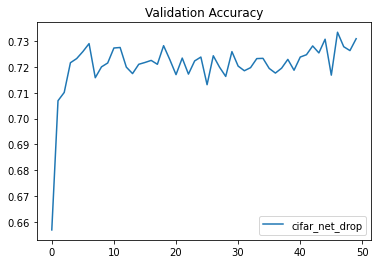

In [17]:
for experiment_id in accuracies.keys():
    plt.plot(accuracies[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Accuracy');

Графическое представление зависимости значений функции потерь от пройденной эпохи:

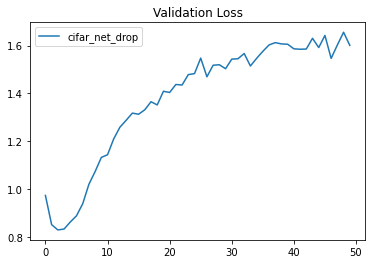

In [18]:
for experiment_id in losses.keys():
    plt.plot(losses[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Loss');

Вывод информации о наборе X_test:

In [19]:
X_test.shape

torch.Size([10000, 3, 32, 32])

Вывод информации о максимальном и минимальном значении в переменной:

In [20]:
X_test.min(), X_test.max()

(tensor(0.), tensor(1.))

Получение информации о конкретном тензоре:

In [21]:
X_test1=X_test[187, :, :, :]
print(y_test[187])

tensor(3)


Вывод информации о размерности тензора:

In [22]:
X_test1 = X_test1.unsqueeze(0)
X_test1.shape

torch.Size([1, 3, 32, 32])

Перенос значения переменной на конкретное вычислительное устройство (GPU или CPU):

In [23]:
X_test1=X_test1.to(device)

Задействование нейронной сети для распознавания образа из переменной:

In [24]:
net.eval()
with torch.no_grad():
     y1 = net.forward(X_test1)

Вывод информации о полученной переменной:

In [25]:
print(y1)

tensor([[  5.0395, -11.4773,  11.3764,   9.2760,  -0.6596,   0.6832,  -1.4805,
          -6.2613,  -2.2974, -11.5385]], device='cuda:0')


Перестановка очерёдности измерений и перенос переменной обратно на CPU для возможности вывода изображения на график:

In [26]:
X_test2=X_test[187, :, :, :]
X_test2 = X_test2.permute(1, 2, 0)
X_test2=X_test2.to('cpu')

Вывод информации о размерности переменной X_test2:

In [27]:
X_test2.shape

torch.Size([32, 32, 3])

Вывод изображения из переменной:

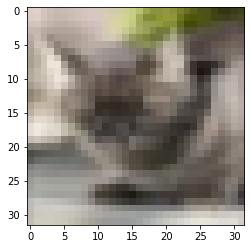

In [28]:
plt.imshow(X_test2)

***
**Задание на лабораторную работу**
***

1. Изучить понятия: **дропаут (dropout)**, **регуляризация**;
2. Исследовать нейронную сеть **CIFARNet без дропаута**. Имеется ли переобучение в этой сети?;
3. Исследовать нейронную сеть **CIFARNet с включенным дропаутом**. Исследовать влияние вероятности дропаута *p* на качество сети;
4. Найти по одному верному и неверному случаю классификации изображения.

***
**Ответы на задание**
***

1. **Дропаут (dropout)** — алгоритм, ориентированный на предотвращение переобучения при помощи исключения из сети нейронов с вероятностью *p* и приравнивание вероятностей данных нейронов к нулю при любых входных параметрах. **Регуляризация** — метод аппроксимации функции потерь, при котором к каждому значению функции добавляется некоторое число, называемое штрафом, штраф рассчитывается исходя из весов нейронной сети, либо с помощью суммы квадратов коэффициентов.
2. Нейронная сеть **CIFARnet без дропаута** показала точность распознавания со значением **0.7309**.
3. Нейронная сеть **CIFARnet с включённым дропаутом** показала точность распознавания со значением **0.7275**.
4. В большинстве итераций нейронная сеть верно классифицирует изображения. Однако для получения ситуации неверной классификации было намеренно создано переобучение, что привело к ошибке в классификации.

**Выводы**: при выполнении лабораторной работы были получены практические навыки оптимизации процесса обучения нейронной сети для предотвращения переобучения. Были освоены такие методики, как **регуляризация**, **ранняя остановка**, **аугментация** и **дропаут**, изучены теоретические основы, в соответствии с которыми оптимизируются результаты обучения, а также рассмотрены различные способы настройки дропаута. Работа проводилась с датасетом CIFAR для того, чтобы обеспечить комплексность анализируемых данных и приблизить процесс обучения к реальным данным.